<a href="https://colab.research.google.com/github/crystalloide/Big_Data/blob/master/Orsys_BID_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# IMPORTANT : CERTAINES SOURCES DE DONNÉES KAGGLE SONT PRIVÉES
# EXÉCUTEZ CETTE CELLULE POUR IMPORTER VOS SOURCES DE DONNÉES KAGGLE.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [20]:
# IMPORTANT : EXÉCUTEZ CETTE CELLULE POUR IMPORTER VOS SOURCES DE DONNÉES KAGGLE,
# PUIS, N'HÉSITEZ PAS À SUPPRIMER CETTE CELLULE.
# REMARQUE : CET ENVIRONNEMENT PORTABLE DIFFÈRE DE L'ENVIRONNEMENT PYTHON DE KAGGLE.
# IL PEUT DONC MANQUER DES BIBLIOTHÈQUES UTILISÉES PAR VOTRE PORTABLE.

titanic_path = kagglehub.competition_download('titanic')

print('Data source import complete.')

!ls
!pwd
!rm gender_submission.csv
!rm test.csv
!rm train.csv
!unzip /titanic.zip

!ls


Data source import complete.
gender_submission.csv  sample_data  test.csv  titanic.zip  train.csv
/content
Archive:  /titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
gender_submission.csv  sample_data  test.csv  titanic.zip  train.csv


# **Tutoriel général de préparation des données**


### Bienvenue dans ce tutoriel de préparation de données. Ce notebook est destiné aux débutants qui souhaitent apprendre à préparer correctement un jeu de données afin de le transmettre à un algorithme de machine learning. Je vous encourage à créer un fork de ce notebook, à tester le code et à l'améliorer !

![](https://2s7gjr373w3x22jf92z99mgm5w-wpengine.netdna-ssl.com/wp-content/uploads/2016/07/shutterstock_data_prep_-faithie.jpg)

### Voici quelques ressources supplémentaires que vous pouvez consulter pour approfondir la compréhension des différentes techniques que nous allons voir dans ce cahier :

[*Gérer les valeurs manquantes*](https://towardsdatascience.com/tag/handling-missing-values/)

[*Ingénierie des fonctionnalités*](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)

[*Pourquoi l'encodage à chaud en apprentissage automatique ?*](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

[*Piège à variables fictives*](https://www.algosome.com/articles/dummy-variable-trap-regression.html)

[*Encodage à chaud*](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding)

[*Mise à l'échelle et Normalisation*](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e)

## **Table des matières**

1. [**Gestion des valeurs manquantes**](#missing)
2. [**Ingénierie des caractéristiques**](#fe)
3. [**Gestion des caractéristiques catégorielles**](#catvar)
4. [**Mise à l'échelle des caractéristiques**](#scaler)

In [96]:
!pip install chart-studio
import pandas as pd
import numpy as np
import missingno as mn
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler

# Remplacement des imports obsolètes de Plotly
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [97]:
# Path of datasets
titanic_df = pd.read_csv('train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## **1. Traitement des valeurs manquantes et des valeurs aberrantes** <a is="missing"></a>

#### Le premier problème rencontré lors de la préparation des données pour leur transmission à un algorithme d'apprentissage automatique est celui des données manquantes. En effet, la plupart des jeux de données, notamment ceux issus de données réelles, présentent des valeurs manquantes. Par exemple, notre jeu de données titanesque présente des valeurs manquantes :

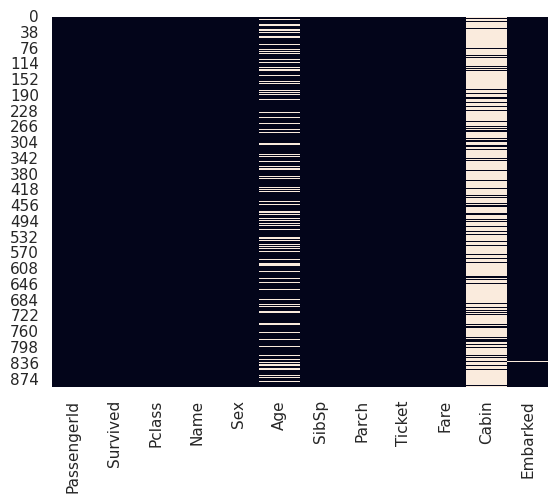

<Axes: >

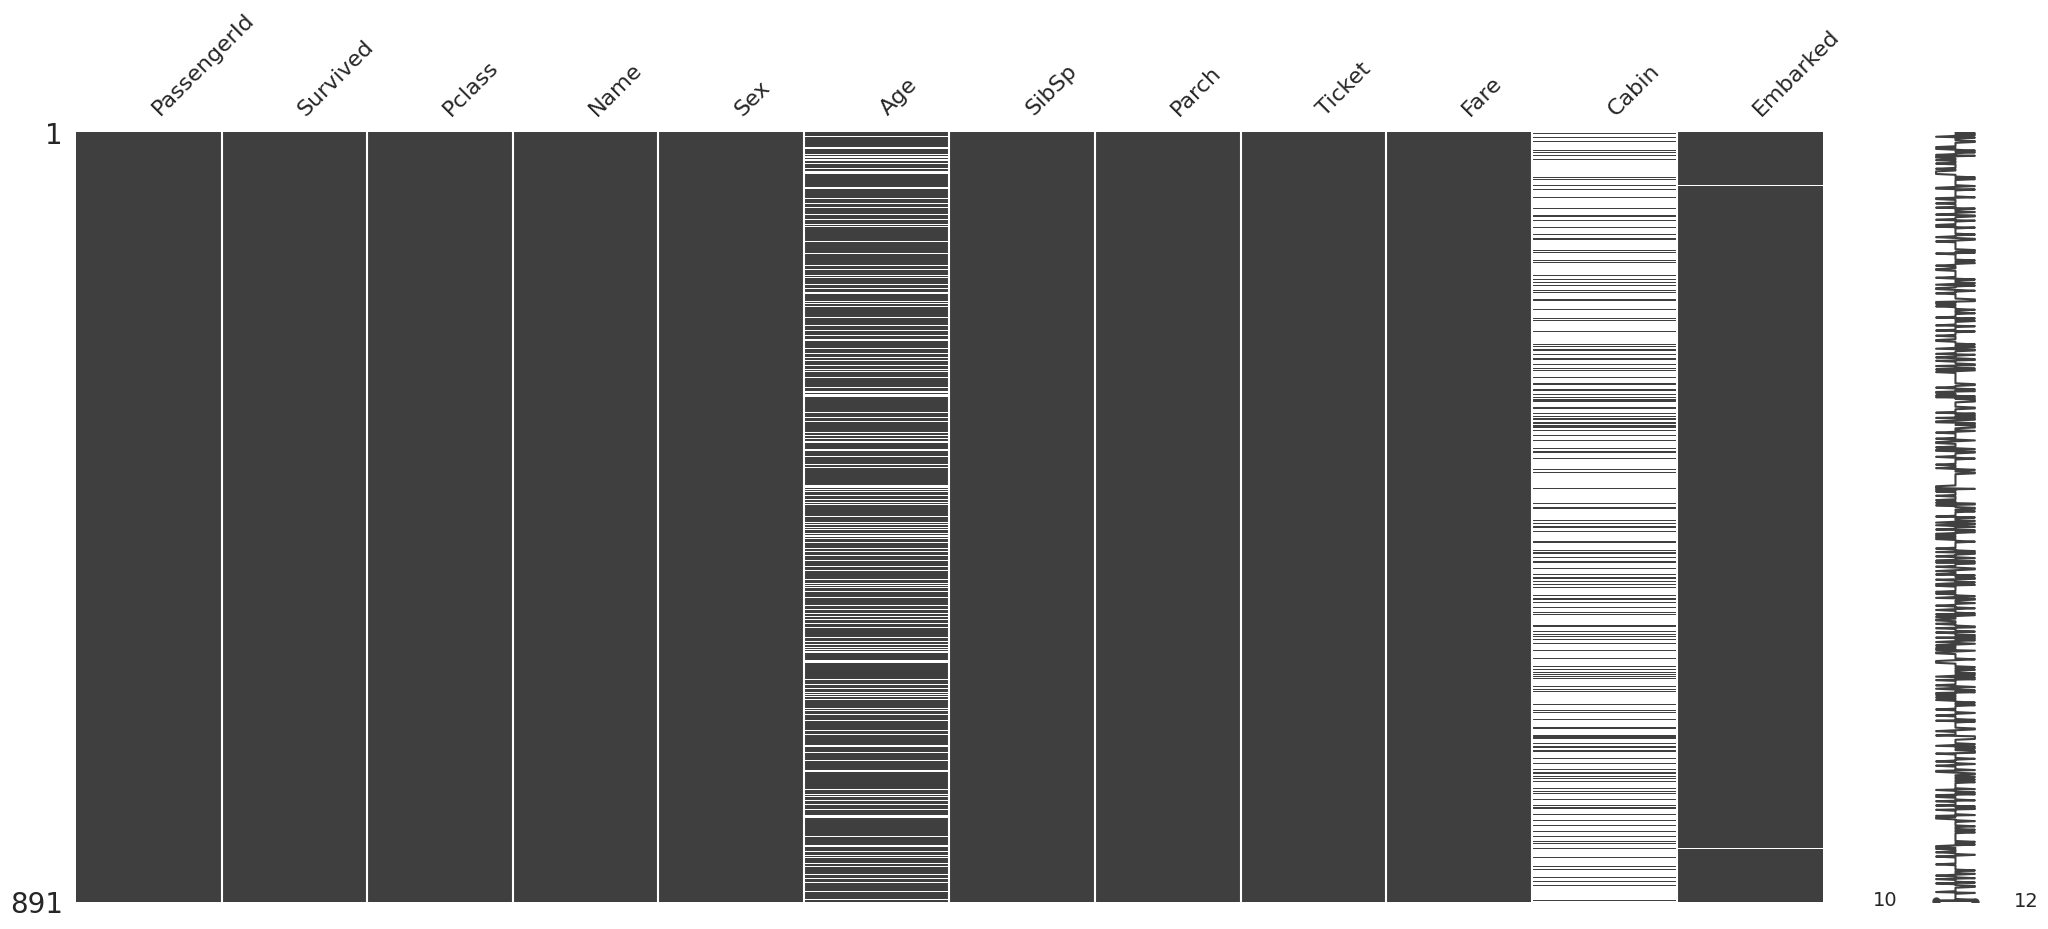

In [87]:
missing_values = titanic_df
sns.heatmap(missing_values.isnull(), cbar=False)
# Option 1 :
plt.show()
# Option 2 :
mn.matrix(missing_values)

### Si une caractéristique (une colonne de notre jeu de données) ne présente pas trop de valeurs manquantes, nous pouvons essayer de les compléter. Il existe plusieurs méthodes pour ce faire :

- S'il y a trop de données manquantes (> 60 %), vous pouvez supprimer la colonne :

titanic_df.drop('Cabin', axis=1, inplace=True)

- S'il y a peu de données manquantes (1 à 2 %), vous pouvez supprimer les lignes contenant NAN :

titanic_df['Age'].dropna(inplace=True)

### Une meilleure solution pour un petit nombre de données manquantes consiste à étudier chaque observation au cas par cas et à remplacer les valeurs manquantes en examinant d'autres caractéristiques de cette observation, puis en essayant de trouver une tendance entre elles afin de déterminer la valeur manquante.

- En général, nous ne souhaitons pas perdre de données. Une solution consiste à remplacer les valeurs manquantes par la moyenne ou la médiane de la colonne. Privilégiez la médiane pour les colonnes contenant des valeurs aberrantes susceptibles de fausser la moyenne.

titanic_df['Age'].fillna(titanic_df['Age'].mean(), 1, inplace=True)
titanic_df['Age'].fillna(titanic_df['Age'].median(), 1, inplace=True)

### La stratégie de remplissage des valeurs manquantes dépend fortement du jeu de données et de votre imagination ! Soyez donc créatifs, demandez-vous pourquoi ces données sont manquantes et comment les remplacer intelligemment ! N'oubliez pas d'essayer différentes méthodes de remplacement et de mesurer leur impact sur les performances de votre modèle. Examinons maintenant notre jeu de données Titanic :

### Il ne manque que deux valeurs pour la colonne « Embarqué ». Essayons de les remplacer. Voici la répartition des « Embarqués » selon le tarif et le sexe, ainsi que les deux observations pour lesquelles la valeur « Embarqué » est manquante. Analysons ces deux observations et choisissons la valeur « Embarqué » la plus adaptée en fonction de leur tarif et de leur sexe :

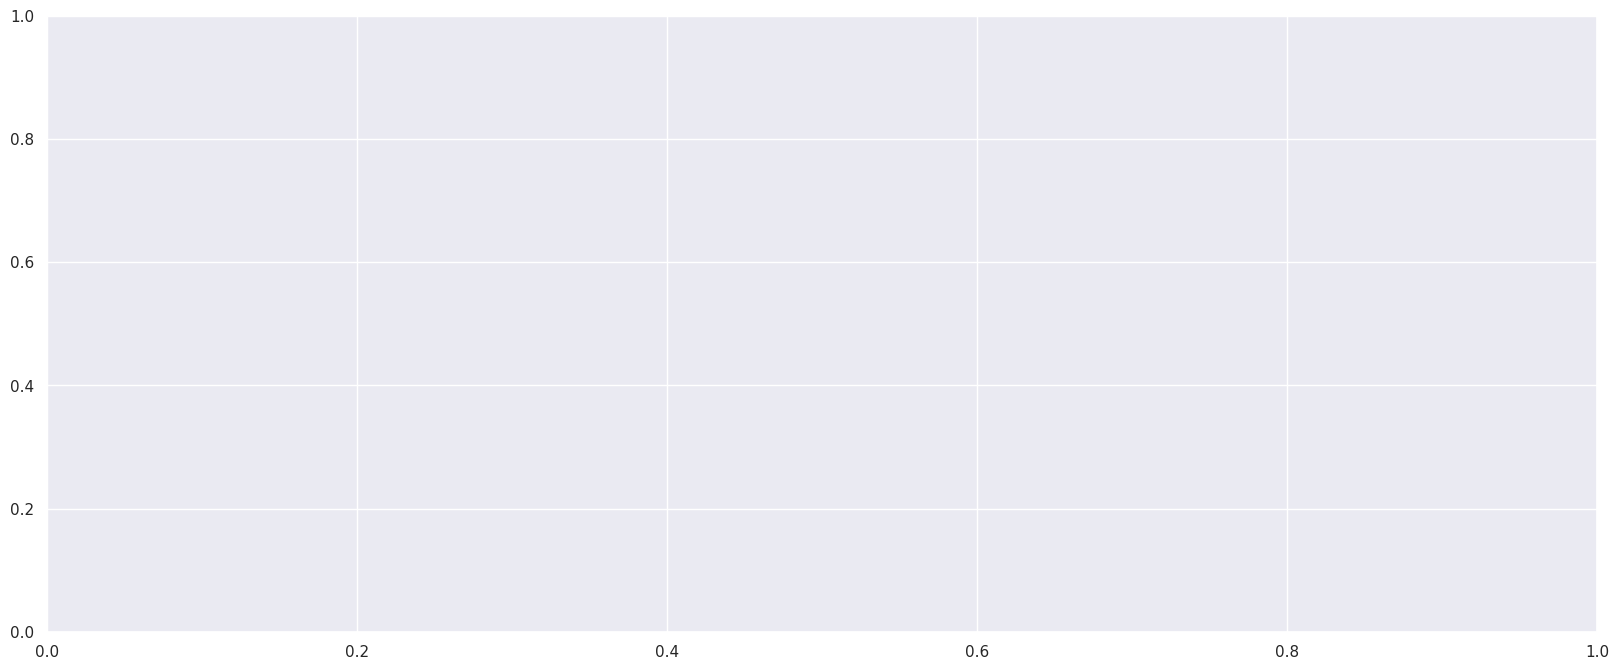

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [95]:
figure, axes = plt.subplots(1,1,figsize=(20, 8))
plot = sns.catplot(x="Embarked", y="Fare", hue="Sex", data=titanic_df, palette=('nipy_spectral'), kind="bar", ax=axes)
plt.close(plot.fig)
plt.show()
display(titanic_df[titanic_df['Embarked'].isnull()])

### Les deux passagères sont des femmes qui ont payé 80 dollars pour leur billet. De plus, elles ont le même billet et la même cabine ; elles ont donc probablement dû embarquer au même endroit ! D'après la distribution ci-dessus, la valeur d'embarquement la plus probable pour elles est Cherbourg (C). Remplaçons ces valeurs manquantes :

In [89]:
titanic_df['Embarked'].fillna('C', inplace=True)

### Pour l'âge, nous avons 177 valeurs manquantes ; c'est beaucoup trop pour les examiner au cas par cas. Nous allons la remplacer par la médiane, même s'il existe peut-être une meilleure solution prenant en compte d'autres colonnes. Si vous trouvez une solution pour remplacer les valeurs d'âge manquantes qui améliore considérablement la précision de votre modèle, n'hésitez pas à la partager dans les commentaires !

In [100]:
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)

### Enfin, la colonne « Cabin » (cabine) permet de trouver le pont où se trouve la cabine du passager : nous la conserverons donc. Remplaçons les valeurs manquantes par « U », c'est-à-dire 'Unkown':

In [101]:
titanic_df['Cabin'].fillna('U', inplace=True)

In [102]:
draw_missing_data_table(titanic_df[['Cabin', 'Age', 'Embarked']])

,Total,Percent
Embarked,2,0.002245
Cabin,0,0.000000
Age,0,0.000000


## **2. Ingénierie des caractéristiques** <a id="fe"></a>

### L'ingénierie des caractéristiques est l'art de créer de nouvelles caractéristiques à partir de caractéristiques existantes ou de connaissances sur les données. Par exemple, une simple recherche sur Internet permet de déterminer que la première lettre de la colonne « cabine » correspond au pont du bateau où se trouve la cabine. Ainsi, nous pouvons créer une entité « Pont » à partir de la caractéristiques « cabine ». Nous pouvons également créer une colonne « Titre » correspondant au titre de chaque passager. La création de caractéristiques est la seule limite ! Mais gardez à l'esprit que l'objectif n'est pas de créer des caractéristiques simplement pour créer des caractéristiques, mais d'améliorer la précision du modèle ! Voici quelques exemples de création de caractéristiques pour le jeu de données Titanic :

In [105]:
# Deck column from letter contained in cabin
titanic_df['Deck'] = titanic_df['Cabin'].str[:1]
titanic_df['Deck'] = titanic_df['Cabin'].map({cabin: p for p, cabin in enumerate(set(cab for cab in titanic_df['Cabin']))})

# Title column from title contained in name
titanic_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in titanic_df['Name']), index=titanic_df.index)
titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic_df['Title'] = titanic_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')

# Famillysize columns obtained by adding number of sibling and parch
titanic_df['FamillySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
titanic_df['FamillySize'][titanic_df['FamillySize'].between(1, 5, inclusive='neither')] = 2
titanic_df['FamillySize'][titanic_df['FamillySize']>5] = 3
titanic_df['FamillySize'] = titanic_df['FamillySize'].map({1: 'Alone', 2: 'Medium', 3: 'Large'})

# IsAlone and IsChild column, quite explicit
titanic_df['IsAlone'] = np.where(titanic_df['FamillySize']!=1, 0, 1)
titanic_df['IsChild'] = titanic_df['Age'] < 18
titanic_df['IsChild'] = titanic_df['IsChild'].astype(int)

### Once we've finished to create our new features, we can delete all useless remaining columns and print the first rows of our dataset:

In [107]:
titanic_df = titanic_df.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,FamillySize,IsAlone,IsChild
0,0,3,male,22.0,1,0,7.2500,S,32,Mr,Medium,0,0
1,1,1,female,38.0,1,0,71.2833,C,10,Mrs,Medium,0,0
2,1,3,female,26.0,0,0,7.9250,S,32,Miss,Alone,0,0
3,1,1,female,35.0,1,0,53.1000,S,45,Mrs,Medium,0,0
4,0,3,male,35.0,0,0,8.0500,S,32,Mr,Alone,0,0


## **3. Handling categorical features** <a id="catvar"></a>

### As you can notice when looking at the dataset above, we've some categorical features in our data. Categorical features are features which values are non-numeric. Here, we have 4 of them : Sex, Embarked, Title, FamillySize. We need to transform it into numeric features in order to pass it to a machine learning algorithm.
### A solution is to transform these features into numeric features can be to map the string values with numeric values. This solution is called label encoding. It can be done easily in Python using LabelEncoder class from scikit learn or map method of a pandas dataframe. For example, to label encode the Embarked column of the titanic dataset we have to transform letters corresponding to the embarked location into a number :

 - Embarked Cherbourg corresponds to 1
 - Embarked Southampton corresponds to 2
 - Embarked Queenstown corresponds to 3

### The problem of doing this is that the algorithm may see this as a ranking between the three values. A better solution is to use hot-one encoding. Hot-one encoding means create one column per value of the source column (it is called a dummy variable), which take only binary values. For example, the embacked column dummy encoded gives us three columns : Embarked_C, Embarked_S, Embarked_Q. A passenger who embarked at southampton will for example have his Embarked_S column set to 1, whereas the two other embarked columns will be set to 0.

![](https://www.renom.jp/notebooks/tutorial/preprocessing/category_encoding/renom_cat_onehot.png)

### However, by doing this, we create a redundant column : with two of the three Embarked colomns, we can guess easily the value of the third column. For example, a passenger with Embarked_C and Embarked_S set to 0 will have necessarily his Embarked_Q column set to 1. In order to avoid that redundance, called the dummy variable trap, we must drop one of the column made when creating a dummy variable.

*Note: One-hot encoding usually helps, but it can varies on a case-by-case basis. Do not hesitate to test the effect of HO encoding on your model to see if you need it.*

### There is a verry simple way to do hot-one encoding in python, the pandas get_dummies function creates hot-one encoding for all categorical features of a dataset. By adding the argument drop_first=True, we drop one column for each dummy variable to dummy encode:

In [108]:
titanic_df = pd.get_dummies(data=titanic_df, drop_first=True)
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Deck,IsAlone,IsChild,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamillySize_Large,FamillySize_Medium
0,0,3,22.0,1,0,7.2500,32,0,0,True,False,True,False,True,False,False,False,True
1,1,1,38.0,1,0,71.2833,10,0,0,False,False,False,False,False,True,False,False,True
2,1,3,26.0,0,0,7.9250,32,0,0,False,False,True,True,False,False,False,False,False
3,1,1,35.0,1,0,53.1000,45,0,0,False,False,True,False,False,True,False,False,True
4,0,3,35.0,0,0,8.0500,32,0,0,True,False,True,False,True,False,False,False,False


## **4. Feature scaling** <a id="scaler"></a>

### Finally, we need to perform normalization on the data. Normalizing the data is necessary because feeding a machine learning model with large or heterogeneous values can trigger large gradient updates that will prevent the gradient descent algorithm from converging. Let's look at the ranges of values for our dataframe:

In [ ]:
ranges = titanic_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck', 'IsChild']].max().to_frame().T
ranges.iplot(kind='bar', xTitle='Features', yTitle='Range', title='Range of feature before scaling')

### Ranges are very heterogeneous. One way to change this is by using features scaling. Features scaling will set each column mean to 0 and each column variance to 1. In python, the StandarScaler class of the scikit-learn module allows us to do it vey easily:

In [ ]:
X = titanic_df.drop(['Survived'], 1)
y = titanic_df['Survived']

# Feature scaling of our data
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)
X.head()

### And ... we are done ! Our dataset is finally ready to go into a machine learning algorithm ! Don't forget to check my two others kernel for this dataset:

- [**Complete Titanic tutorial with ML, NN & Ensembling**](https://www.kaggle.com/nhlr21/complete-titanic-tutorial-with-ml-nn-ensembling)
- [**Titanic colorful EDA**](https://www.kaggle.com/nhlr21/titanic-colorful-eda)